<a href="https://colab.research.google.com/github/sdd261/computer-vision/blob/main/Custom_Training_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Custom Training Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2!

# Install detectron2

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.2 ; cuda:  cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-kesvgrzt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-kesvgrzt
  Resolved https://github.com/facebookresearch/detectron2.git to commit b7c7f4ba82192ff06f2bbb162b9f67b00ea55867
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content/drive/MyDrive/Classes/Detectron2_detection'

In [ ]:
%cd /content/drive/MyDrive/Classes/Detectron2_detection

/content/drive/MyDrive/Classes/Detectron2_detection


In [ ]:
!ls

Custom_Training_Detectron2.ipynb  data_detectron2.zip  Detectron2_Setup_Colab.ipynb  Matarials


In [ ]:
!unzip data_detectron2.zip

Archive:  data_detectron2.zip
   creating: data_detectron2/
  inflating: data_detectron2/output.json  
   creating: data_detectron2/train/
  inflating: data_detectron2/train/cam_image1.jpg  
  inflating: data_detectron2/train/cam_image10.jpg  
  inflating: data_detectron2/train/cam_image11.jpg  
  inflating: data_detectron2/train/cam_image12.jpg  
  inflating: data_detectron2/train/cam_image13.jpg  
  inflating: data_detectron2/train/cam_image14.jpg  
  inflating: data_detectron2/train/cam_image15.jpg  
  inflating: data_detectron2/train/cam_image16.jpg  
  inflating: data_detectron2/train/cam_image17.jpg  
  inflating: data_detectron2/train/cam_image18.jpg  
  inflating: data_detectron2/train/cam_image19.jpg  
  inflating: data_detectron2/train/cam_image20.jpg  
  inflating: data_detectron2/train/cam_image21.jpg  
  inflating: data_detectron2/train/cam_image22.jpg  
  inflating: data_detectron2/train/cam_image23.jpg  
  inflating: data_detectron2/train/cam_image24.jpg  
  inflating: d

In [ ]:
%cd data_detectron2

/content/drive/MyDrive/Classes/Detectron2_detection/data_detectron2


# Register data

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("customtrain1", {}, "./output.json", "./train")

In [ ]:
sample_metadata = MetadataCatalog.get("customtrain1")
dataset_dicts = DatasetCatalog.get("customtrain1")

WARNING [04/15 05:10:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 05:10:13 d2.data.datasets.coco]: Loaded 290 images in COCO format from ./output.json


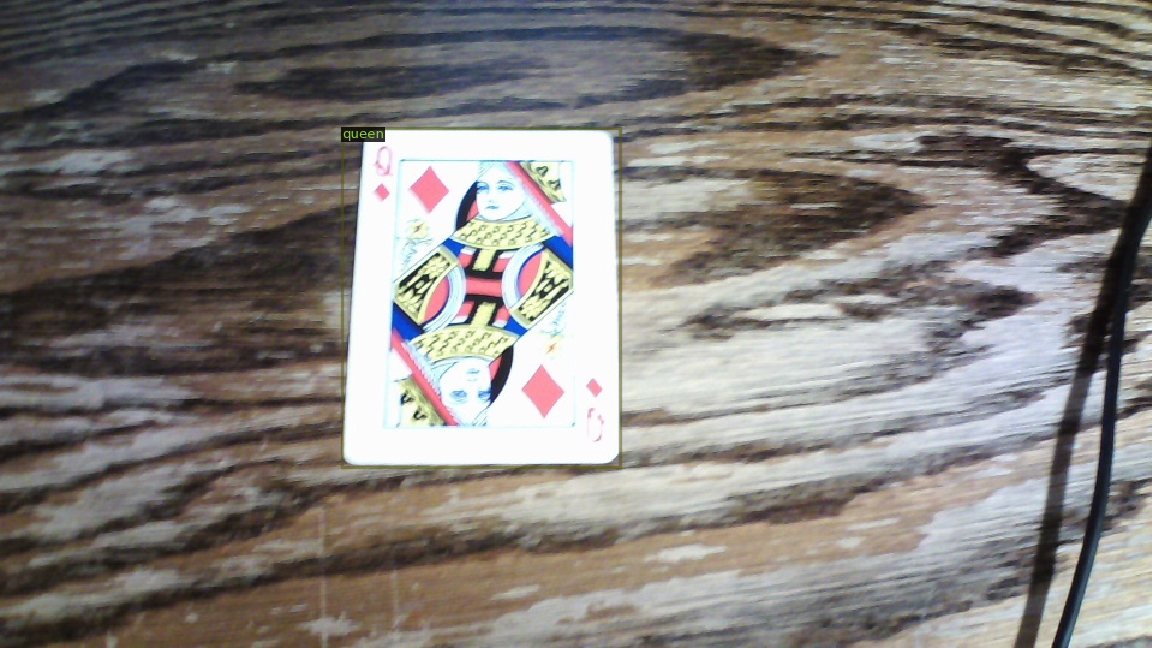

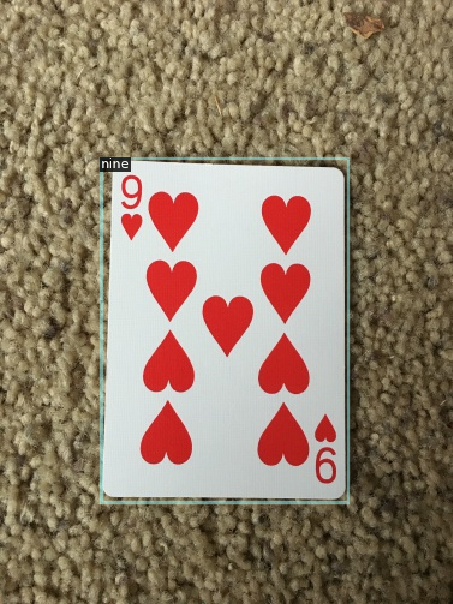

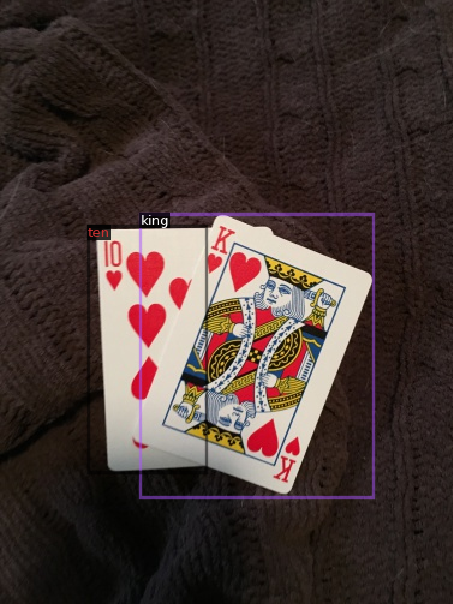

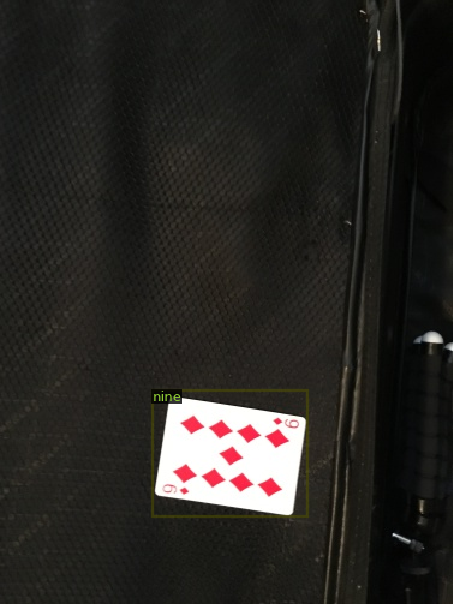

In [ ]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Training

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("customtrain1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 100   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[04/15 05:13:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:07, 21.0MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/15 05:13:48 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/15 05:13:59 d2.utils.events]:  eta: 0:00:29  iter: 19  total_loss: 2.169  loss_cls: 1.316  loss_box_reg: 0.7571  loss_rpn_cls: 0.006371  loss_rpn_loc: 0.005592    time: 0.3892  last_time: 0.4906  data_time: 0.0195  last_data_time: 0.0386   lr: 0.00047703  max_mem: 2547M
[04/15 05:14:10 d2.utils.events]:  eta: 0:00:21  iter: 39  total_loss: 1.393  loss_cls: 0.5448  loss_box_reg: 0.8017  loss_rpn_cls: 0.001392  loss_rpn_loc: 0.004524    time: 0.3868  last_time: 0.4144  data_time: 0.0104  last_data_time: 0.0054   lr: 0.00097653  max_mem: 2547M
[04/15 05:14:17 d2.utils.events]:  eta: 0:00:14  iter: 59  total_loss: 1.24  loss_cls: 0.4892  loss_box_reg: 0.7439  loss_rpn_cls: 0.0002602  loss_rpn_loc: 0.004191    time: 0.3768  last_time: 0.3654  data_time: 0.0083  last_data_time: 0.0098   lr: 0.001476  max_mem: 2547M
[04/15 05:14:25 d2.utils.events]:  eta: 0:00:07  iter: 79  total_loss: 0.9253  loss_cls: 0.4708  loss_box_reg: 0.4333  loss_rpn_cls: 0.0001525  loss_rpn_loc: 0.01028    time: 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("customtrain1", )
predictor = DefaultPredictor(cfg)

[04/15 05:16:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


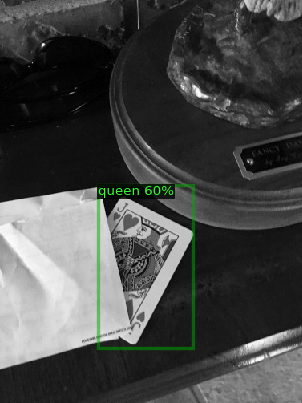

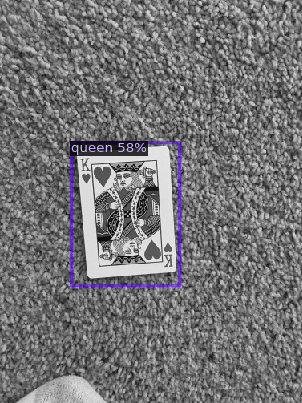

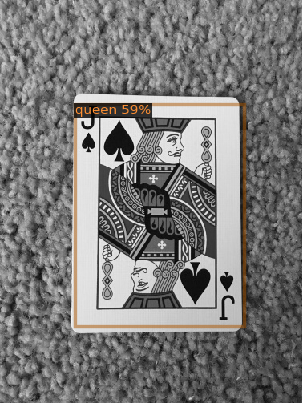

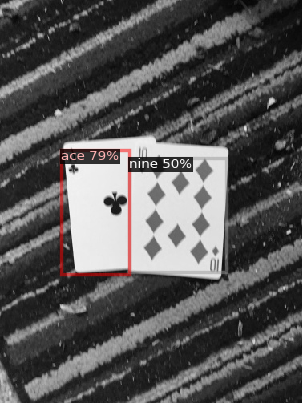

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
%cd data_detectron2

[Errno 2] No such file or directory: 'data_detectron2'
/content/drive/MyDrive/Classes/Detectron2_detection/data_detectron2


# Evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("customtrain1", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "customtrain1")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [04/15 05:18:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 05:18:27 d2.data.datasets.coco]: Loaded 290 images in COCO format from ./output.json
[04/15 05:18:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/15 05:18:27 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/15 05:18:27 d2.data.common]: Serializing 290 elements to byte tensors and concatenating them all ...
[04/15 05:18:27 d2.data.common]: Serialized dataset takes 0.07 MiB
[04/15 05:18:28 d2.evaluation.evaluator]: Start inference on 290 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/15 05:18:29 d2.evaluation.evaluator]: Inference done 11/290. Dataloading: 0.0019 s/iter. Inference: 0.0995 s/iter. Eval: 0.0002 s/iter. Total: 0.1016 s/iter. ETA=0:00:28
[04/15 05:18:34 d2.evaluation.evaluator]: Inference done 60/290. Dataloading: 0.0031 s/iter. Inference: 0.0998 s/iter. Eval: 0.0003 s/iter. Total: 0.1033 s/iter. ETA=0:00:23
[04/15 05:18:39 d2.evaluation.evaluator]: Inference done 109/290. Dataloading: 0.0028 s/iter. Inference: 0.0997 s/iter. Eval: 0.0003 s/iter. Total: 0.1029 s/iter. ETA=0:00:18
[04/15 05:18:44 d2.evaluation.evaluator]: Inference done 158/290. Dataloading: 0.0026 s/iter. Inference: 0.0997 s/iter. Eval: 0.0003 s/iter. Total: 0.1026 s/iter. ETA=0:00:13
[04/15 05:18:49 d2.evaluation.evaluator]: Inference done 204/290. Dataloading: 0.0033 s/iter. Inference: 0.1004 s/iter. Eval: 0.0003 s/iter. Total: 0.1041 s/iter. ETA=0:00:08
[04/15 05:18:54 d2.evaluation.evaluator]: Inference done 252/290. Dataloading: 0.0031 s/iter. Inference: 0.1008 s/iter. Eval: 0

### Getting the custom config file

In [ ]:
pwd

'/content/drive/MyDrive/Classes/Detectron2_detection/data_detectron2'

In [ ]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()